### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time
import datetime
import requests
from sklearn.preprocessing import OneHotEncoder

In [3]:
tf.__version__

'2.5.0'

### Characters to be recognized

In [4]:
save_name='model_9.1'
epochs = 100
batch_size = 32
seed = 0
all_labels=False

In [5]:
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
if all_labels:
      labels=[
        'abraham_grampa_simpson',
        'agnes_skinner',
        'apu_nahasapeemapetilon',
        'barney_gumble',
        'bart_simpson',
        'brandine_spuckler',
        'carl_carlson',
        'charles_montgomery_burns',
        'chief_wiggum',
        'cletus_spuckler',
        'comic_book_guy',
        'disco_stu',
        'dolph_starbeam',
        'duff_man',
        'edna_krabappel',
        'fat_tony',
        'gary_chalmers',
        'gil',
        'groundskeeper_willie',
        'homer_simpson',
        'jimbo_jones',
        'kearney_zzyzwicz',
        'kent_brockman',
        'krusty_the_clown',
        'lenny_leonard',
        'lionel_hutz',
        'lisa_simpson',
        'lunchlady_doris',
        'maggie_simpson',
        'marge_simpson',
        'martin_prince',
        'mayor_quimby',
        'milhouse_van_houten',
        'miss_hoover',
        'moe_szyslak',
        'ned_flanders',
        'nelson_muntz',
        'otto_mann',
        'patty_bouvier',
        'principal_skinner',
        'professor_john_frink',
        'rainier_wolfcastle',
        'ralph_wiggum',
        'selma_bouvier',
        'sideshow_bob',
        'sideshow_mel',
        'snake_jailbird',
        'troy_mcclure',
        'waylon_smithers']
else:
      labels=[ 
              'bart_simpson', 
              'charles_montgomery_burns', 
              'homer_simpson', 
              'krusty_the_clown', 
              'lisa_simpson', 
              'marge_simpson', 
              'milhouse_van_houten', 
              'moe_szyslak', 
              'ned_flanders', 
              'principal_skinner']

In [27]:
!pip install gdown

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=883a3742e8cff70d9bfa97c78a522d26b49fd03cbd489e678581d59735d3362d
  Stored in directory: c:\users\daniel\appdata\local\pip\cache\wheels\7d\37\b6\b2a79c75e898c0b8e46ff255102602d7159a10d9af0d80641a
Successfully built gdown


In [30]:
import gdown
#https://drive.google.com/open?id=1sXAGbJXjGAvMMwbAgzh6lV-leVTShlGZ
id = '1sXAGbJXjGAvMMwbAgzh6lV-leVTShlGZ'
output = './new_dataset.7z'
gdown.download(id=id, output=output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1sXAGbJXjGAvMMwbAgzh6lV-leVTShlGZ
To: c:\Users\Daniel\Documents\GitHub\machine-learning-codes\Simpsons-Face-Recognition\new_dataset.7z
100%|██████████| 214M/214M [03:15<00:00, 1.10MB/s] 


'./new_dataset.7z'

In [31]:

import py7zr
archive = py7zr.SevenZipFile('new_dataset.7z', mode='r')
archive.extractall(path="./")
archive.close()

In [32]:
train_path = 'new_dataset/train/'
test_path = 'new_dataset/test/'

In [33]:
def create_dataset(path,labels):
    onehot_encoder = OneHotEncoder(sparse=False)
    x_data=np.zeros([0,64,64,3])
    y_data=np.zeros([0,1])
    for i,name in enumerate(labels):
        with open(path+name+'.pkl','rb') as file:
            x_tmp = pickle.load(file)/255
            y_tmp = np.ones([len(x_tmp),1])*i
            
            x_data = np.concatenate((x_data,x_tmp))
            y_data = np.concatenate((y_data,y_tmp))
    y_data = onehot_encoder.fit_transform(y_data)
    x_data=tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(x_data,dtype=tf.float32))
    y_data=tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(y_data,dtype=tf.float32))
    
    return tf.data.Dataset.zip((x_data,y_data))


In [34]:
train_data = create_dataset(train_path,labels)
train_data = train_data.shuffle(buffer_size=len(train_data),seed=seed,reshuffle_each_iteration=True)
train_data = train_data.batch(batch_size)


test_data = create_dataset(test_path,labels)
test_data = test_data.shuffle(buffer_size=len(test_data),seed=seed,reshuffle_each_iteration=True)
test_data = test_data.batch(batch_size)

In [35]:
iterador=iter(train_data)
sample_imgs,sample_labels=next(iterador)
decoder=np.arange(len(labels)).reshape([-1,1])
decoded_labels=np.argmax(tf.make_ndarray(tf.make_tensor_proto(sample_labels)),axis=1)

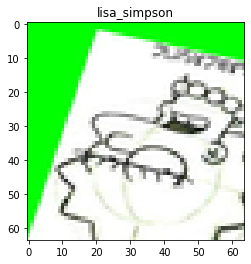

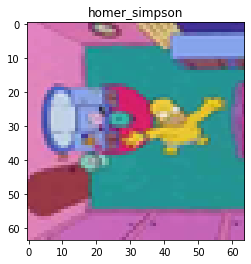

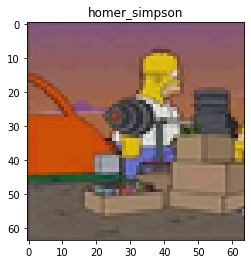

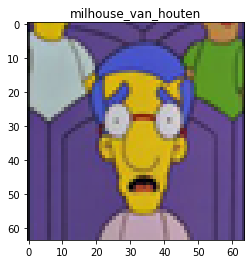

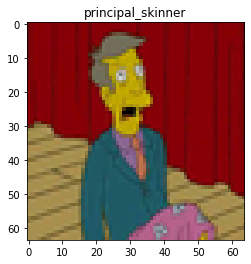

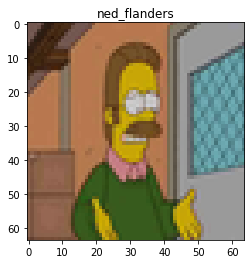

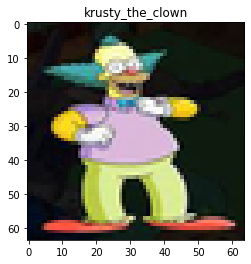

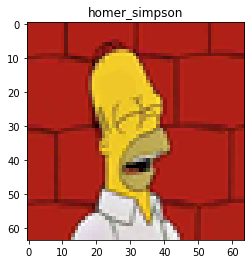

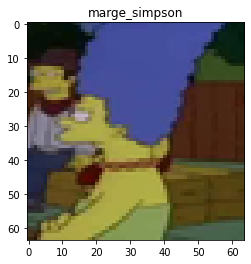

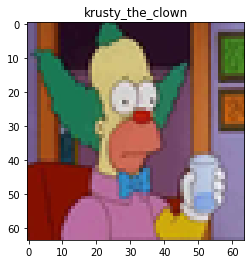

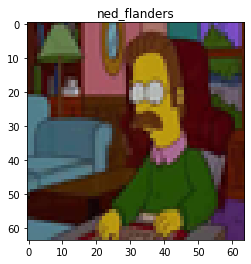

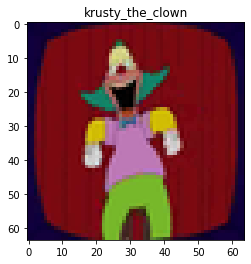

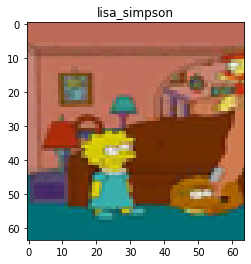

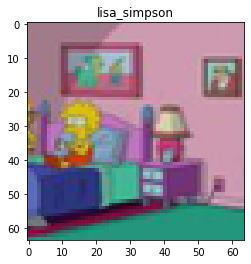

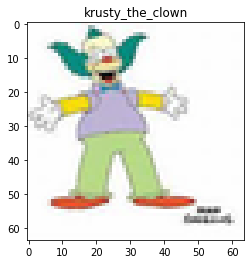

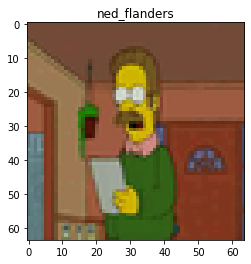

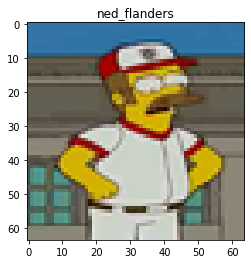

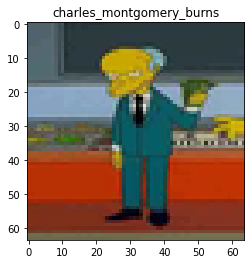

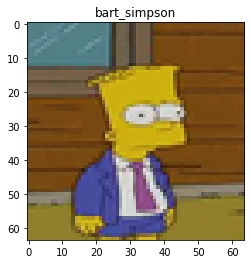

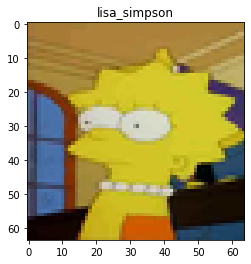

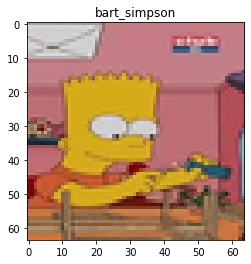

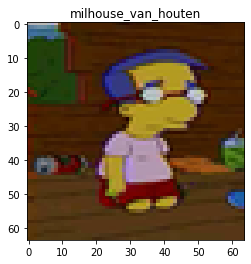

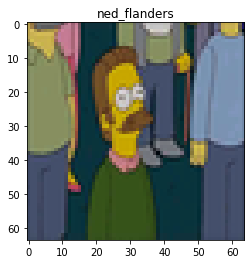

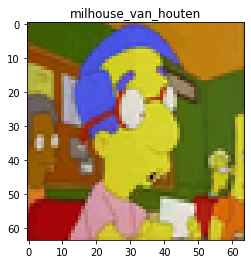

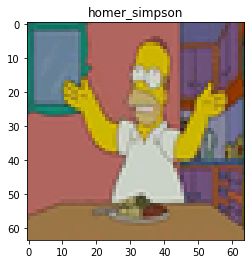

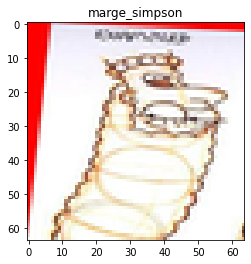

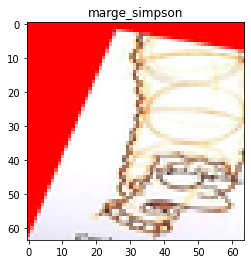

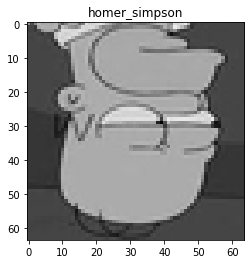

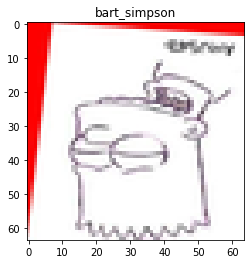

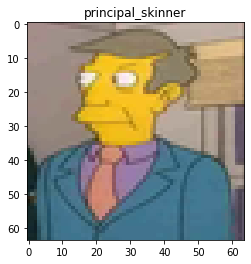

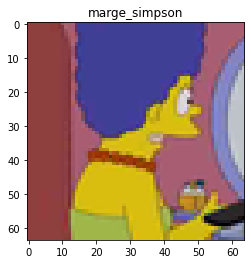

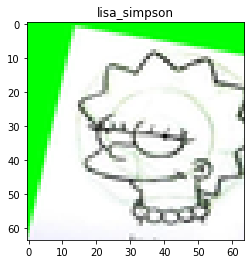

In [36]:
for i in range(len(sample_imgs)):
    plt.imshow(sample_imgs[i])
    plt.title(labels[decoded_labels[i]])
    plt.show()

### Epochs, batch size and samples per set

Load the images and resize. These images are in grayscale, so expected input size

In [37]:
class DNN_model(object):

    def __init__(self,
                   n_classes=10, filtros=[32,64]):
        self.filtros=filtros
        initializer = tf.keras.initializers.GlorotNormal()
        self.hw=[tf.Variable(np.random.rand(3,3,3,filtros[0]),name="hl1weigths",dtype="float32")]
        self.hb=[tf.Variable(np.random.rand(filtros[0]),name="hl1bias",dtype="float32")]
        self.bn=[tf.keras.layers.BatchNormalization()]
        for i in range(1,len(filtros)):
            self.hw.append(tf.Variable(np.random.rand(3,3,filtros[i-1],filtros[i]),name="hl{}weigths".format(i+1),dtype="float32"))
            self.hb.append(tf.Variable(np.random.rand(filtros[i]),name="hl{}bias".format(i+1),dtype="float32"))
            self.bn.append(tf.keras.layers.BatchNormalization())
        
        #8
        self.hw.append(tf.Variable(initializer(shape=(16*16*filtros[-1],512)),name="hl7weigths",dtype="float32"))
        self.hb.append(tf.Variable(np.random.rand(512),name="hl7bias",dtype="float32"))
        self.bn.append(tf.keras.layers.BatchNormalization())
        
        self.hw.append(tf.Variable(initializer(shape=(512,256)),name="hl7weigths",dtype="float32"))
        self.hb.append(tf.Variable(np.random.rand(256),name="hl7bias",dtype="float32"))
        self.bn.append(tf.keras.layers.BatchNormalization())
        
        self.hw.append(tf.Variable(initializer(shape=(256, n_classes)),name="outweigths",dtype="float32"))
        self.hb.append(tf.Variable(np.random.rand(n_classes),name="outbias",dtype="float32"))
        
        self.trainable_variables=[]
        for i in range(len(self.hw)):
            self.trainable_variables.append(self.hw[i])
            self.trainable_variables.append(self.hb[i])
        
        
    def __call__(self,x,train_mode=False):

        index=0
        layer = tf.nn.conv2d(x,self.hw[index], strides=[1,1,1,1], padding='SAME')      
        layer = tf.add(layer, self.hb[index])
        layer = self.bn[index](layer)
        layer = tf.nn.relu(layer)
        layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        if train_mode: layer = tf.nn.dropout(layer,0.5) 
        
        index+=1
        layer = tf.nn.conv2d(layer,self.hw[index], strides=[1,1,1,1], padding='SAME')  
        layer = tf.add(layer, self.hb[index])
        layer = self.bn[index](layer,train_mode)
        layer = tf.nn.relu(layer)
        layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        if train_mode: layer = tf.nn.dropout(layer,0.3) 
 
        index+=1
        layer=  tf.reshape(layer,[-1, 16*16*self.filtros[-1]])
        layer=  tf.matmul(layer,self.hw[index])
        layer = tf.add(layer, self.hb[index])
        layer = self.bn[index](layer,train_mode)
        layer = tf.nn.relu(layer)
        if train_mode: layer = tf.nn.dropout(layer,0.5) 
        
        index+=1
        layer =  tf.matmul(layer,self.hw[index])
        layer = tf.add(layer, self.hb[index])
        layer = self.bn[index](layer,train_mode)
        layer = tf.nn.relu(layer)
        if train_mode: layer = tf.nn.dropout(layer,0.5) 

        output =  tf.matmul(layer,self.hw[-1])
        output = tf.add(output, self.hb[-1])
        return output

        
    def save(self,name):
        with open(name+'.h5', 'wb') as pfile:
            variables=(self.hw,self.hb,self.bn)
            pickle.dump(variables, pfile, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load(self,name):
        with open(name+'.h5', 'rb') as pfile:
            (self.hw,self.hb,self.bn)=pickle.load(pfile)
            self.trainable_variables=[]
            for i in range(len(self.hw)):
                self.trainable_variables.append(self.hw[i])
                self.trainable_variables.append(self.hb[i])
        

In [38]:
DNN = DNN_model(len(labels))
DNN(np.random.rand(128,64,64,3))

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[-2441.3755 ,  1345.4297 , -2041.5486 , ...,  1643.291  ,
          337.9336 ,   675.89154],
       [-2270.9685 ,  1339.9939 , -2080.249  , ...,  1712.619  ,
          162.38507,   668.07275],
       [-2398.2166 ,  1336.7085 , -2030.6421 , ...,  1698.3348 ,
          339.3462 ,   691.613  ],
       ...,
       [-2374.0842 ,  1246.0203 , -2037.7258 , ...,  1730.7534 ,
          262.9546 ,   528.94836],
       [-2410.582  ,  1377.3042 , -2056.4072 , ...,  1669.1909 ,
          272.6449 ,   637.24243],
       [-2348.773  ,  1410.2018 , -2068.2517 , ...,  1644.714  ,
          140.52594,   658.6206 ]], dtype=float32)>

In [40]:
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001,epsilon=1e-7)

In [41]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [42]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata,True)
        #calculo de una funcion de error 
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [43]:
@tf.function
def test_step(model,tdata, labels):
    predictions = model(tdata)
    t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [44]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [45]:

def fitting(model,train_data,test_data,start,EPOCHS,batch_size):
    best_acc=0
    for epoch in range(start,start+EPOCHS):
        tic=time.time()
        for batch_x, batch_y in train_data:
                train_step(model,batch_x,batch_y)
        for batch_x, batch_y in test_data:
                test_step(model,batch_x,batch_y)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
        
        if test_accuracy.result()>best_acc:
            best_acc=test_accuracy.result()
            model.save(save_name+"_best")

        template = 'Epoch {:02d}, Tiempo: {:.1f}s Perdida: {:.6f}, Exactitud: {:.2f}, Perdida de prueba: {:.6f}, Exactitud de prueba: {:.2f}'
        print(template.format(epoch+1,
                              (time.time()-tic),
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

In [46]:
fitting(DNN,train_data,test_data,0,epochs,batch_size)

Epoch 01, Tiempo: 11.5s Perdida: 2.099487, Exactitud: 26.97, Perdida de prueba: 1.740589, Exactitud de prueba: 21.80
Epoch 02, Tiempo: 8.6s Perdida: 1.922618, Exactitud: 29.68, Perdida de prueba: 1.650529, Exactitud de prueba: 30.86
Epoch 03, Tiempo: 8.6s Perdida: 1.858212, Exactitud: 32.01, Perdida de prueba: 1.522480, Exactitud de prueba: 39.35
Epoch 04, Tiempo: 8.3s Perdida: 1.817633, Exactitud: 33.87, Perdida de prueba: 1.583141, Exactitud de prueba: 40.22
Epoch 05, Tiempo: 8.2s Perdida: 1.793805, Exactitud: 35.06, Perdida de prueba: 1.523700, Exactitud de prueba: 35.18
Epoch 06, Tiempo: 8.2s Perdida: 1.769832, Exactitud: 36.20, Perdida de prueba: 1.761082, Exactitud de prueba: 24.82
Epoch 07, Tiempo: 8.3s Perdida: 1.732079, Exactitud: 37.75, Perdida de prueba: 1.515281, Exactitud de prueba: 32.73
Epoch 08, Tiempo: 8.4s Perdida: 1.721140, Exactitud: 38.18, Perdida de prueba: 1.410239, Exactitud de prueba: 43.02
Epoch 09, Tiempo: 8.3s Perdida: 1.697064, Exactitud: 38.57, Perdida de 

In [47]:
DNN.save(save_name)

In [48]:
DNN = DNN_model(len(labels))
DNN.load(save_name)

In [49]:
iterador=iter(test_data)
sample_imgs,sample_labels=next(iterador)
decoder=np.arange(len(labels)).reshape([-1,1])
decoded_labels=np.argmax(tf.make_ndarray(tf.make_tensor_proto(sample_labels)),axis=1)
predicted_labels=DNN(sample_imgs)
p_decoded_labels=np.argmax(tf.make_ndarray(tf.make_tensor_proto(predicted_labels)),axis=1)

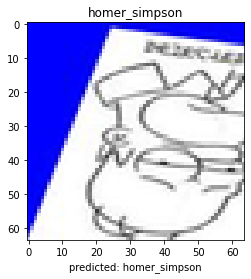

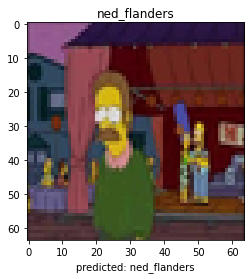

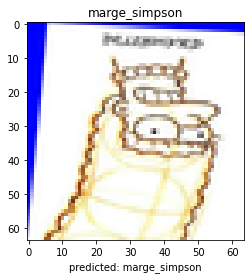

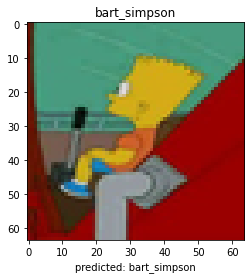

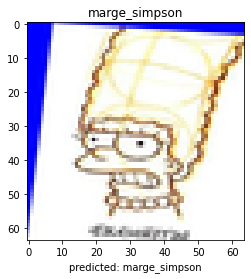

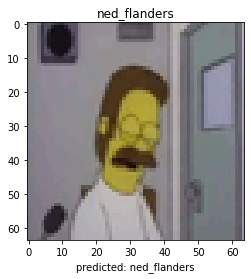

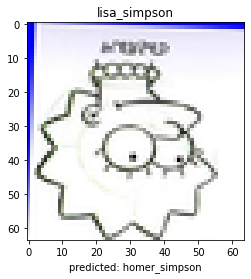

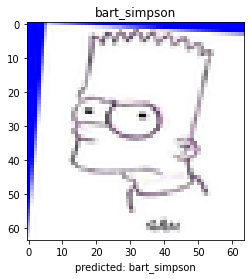

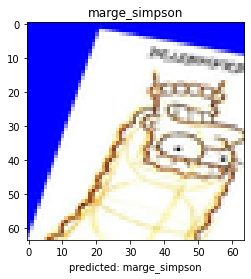

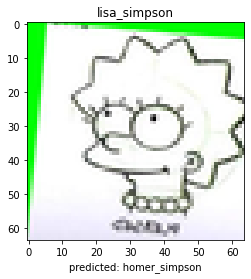

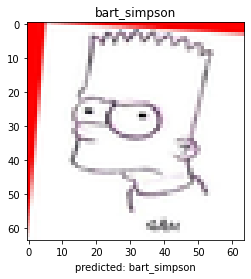

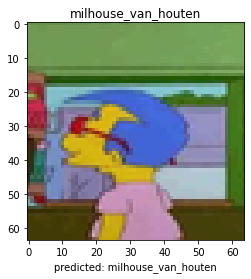

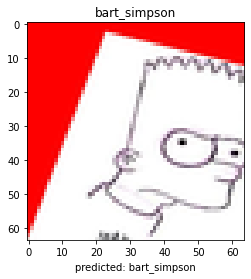

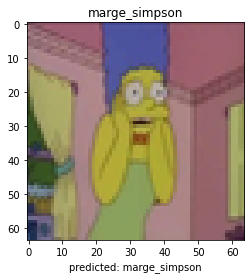

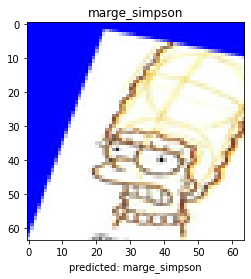

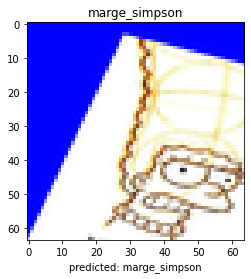

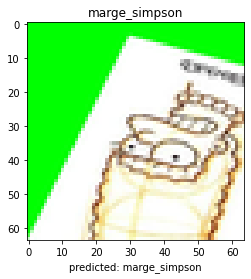

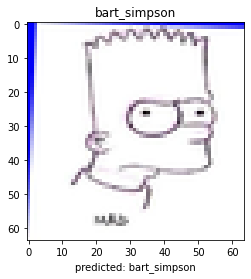

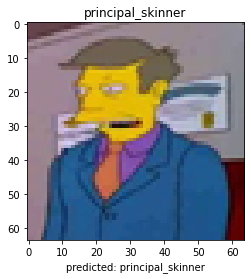

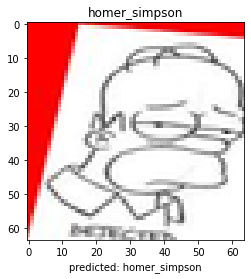

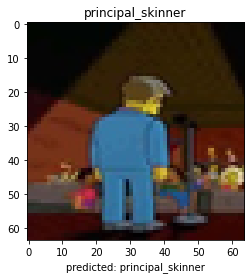

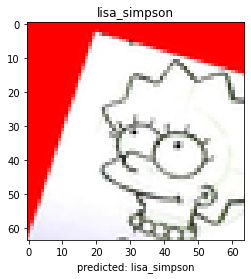

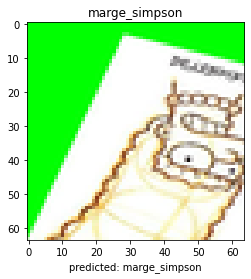

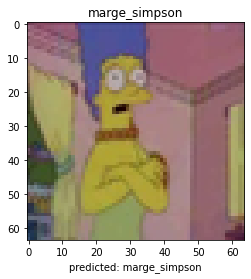

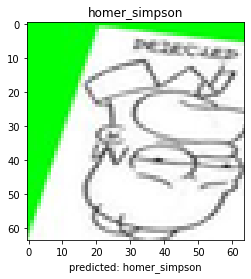

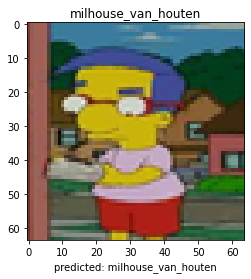

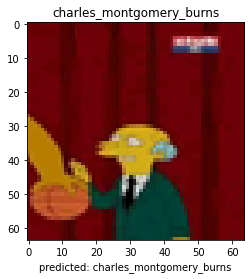

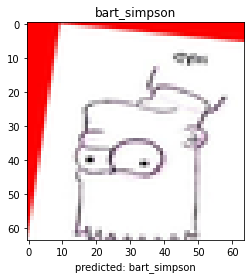

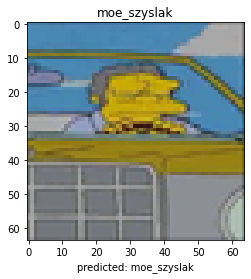

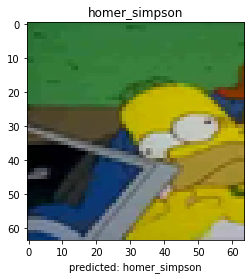

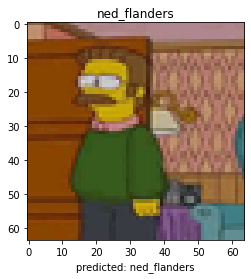

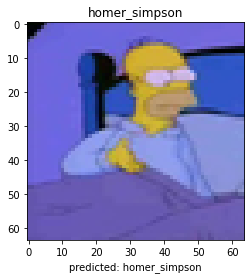

In [50]:
for i in range(len(sample_imgs)):
    plt.imshow(sample_imgs[i])
    plt.title(labels[decoded_labels[i]])
    plt.xlabel('predicted: '+labels[p_decoded_labels[i]])
    plt.show()